# 4.3 多層パーセプトロンのバックプロパゲーションで画像分類問題を解く

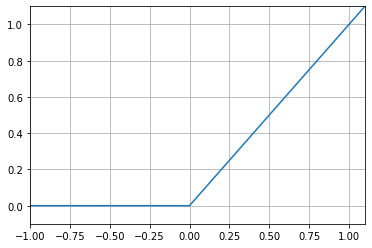

In [1]:
# 4-03-1 ReLU関数の出力をグラフにする
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as  np

def relu(x):
    y = np.maximum(0, x)
    return y

x = np.arange(-6, 6, 0.1)
y = relu(x)

fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.plot(x, y)
ax.set_xlim(-1, 1.1)
ax.set_ylim(-0.1, 1.1)
ax.grid()

plt.show()

## 10種類のファッションアイテムの画像データ [Fashion-MNIST]

$28 \times 28$ の白黒画像。

<pre>
0  Tシャツ/トップス
1  ズボン
2  プルオーバー
3  ドレス
4  コート
5  サンダル
6  シャツ
7  スニーカー
8  バッグ
9  アンクルブーツ
</pre>

In [2]:
# 4-03-2 Fashion-MNIST をダウンロードして変数に代入する
# p.204

from tensorflow import keras

(x_train, t_train), (x_test, t_test) = keras.datasets.fashion_mnist.load_data() 

In [3]:
print(x_train.shape)
print(t_train.shape)
print(x_test.shape)
print(t_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [4]:
class_names = [
    'T-shirt/top',
    'Trouser',
    'Pullover',
    'Dress',
    'Coat',
    'Sandal',
    'Shirt',
    'Sneaker',
    'Bag',
    'Ankle boot'
]

In [5]:
import numpy as np

n_lines = 5
n_rows = 10

select_indices = np.random.choice(range(len(x_train)), n_lines * n_rows)

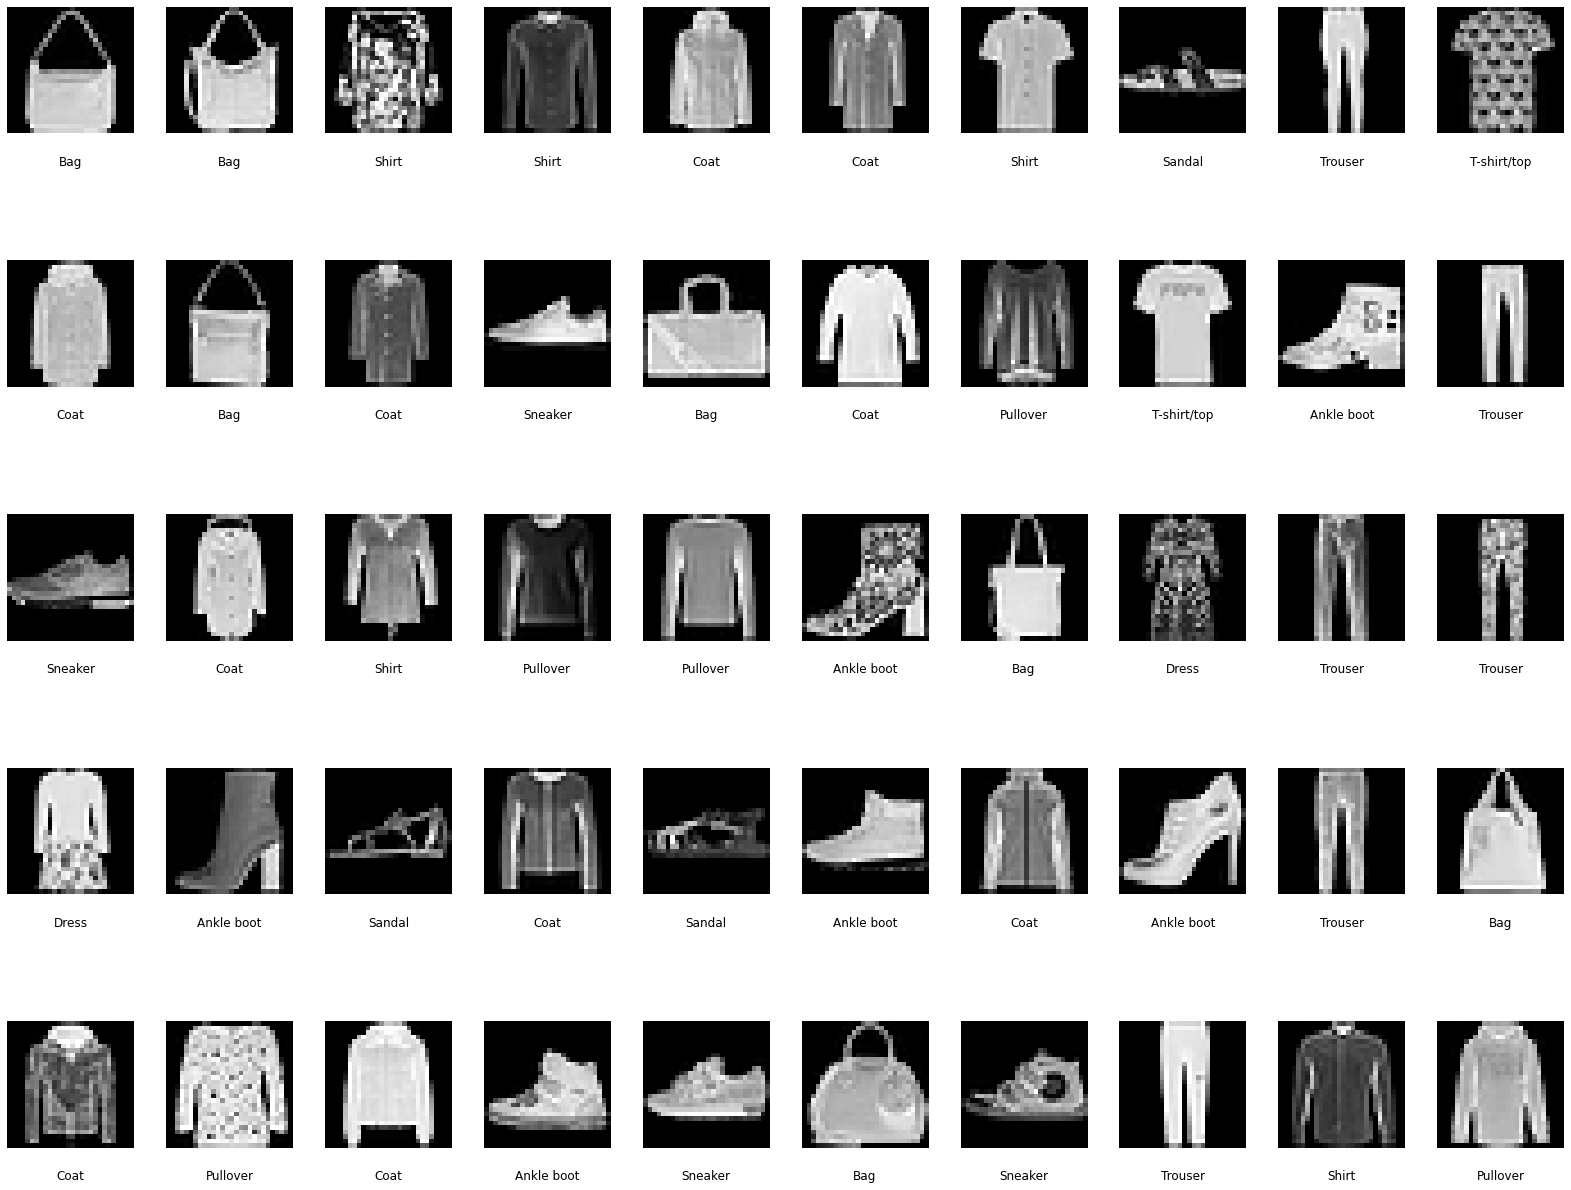

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, ax = plt.subplots(n_lines, n_rows, figsize=(2.8 * n_rows, 2.8 * n_lines * 1.5))
plt.subplots_adjust(hspace=1)

for i in range(len(select_indices)):
    line = i // n_rows
    row = i % n_rows
    idx = select_indices[i]
    ax[line][row].imshow(x_train[idx], cmap='gray')
    ax[line][row].text(0.5, -0.25, class_names[t_train[idx]],fontsize=12, ha='center', transform=ax[line][row].transAxes)
    ax[line][row].axis('off')
    
plt.show()

## Fashion-MNIST データの前処理

画像データは0～255の値を持つが、sigmoid関数やsoftmax関数は[0.0, 1.0]の値を出力するので、
入力データを正規化して[0.0, 1.0]の間の値に変換する。

In [7]:
# 4-03-6 (28, 28) の画像データを(784)のベクトルに変換してから、正規化する

x_train_rs = x_train.reshape((-1, 28*28)).astype('float32') / 255
x_test_rs = x_test.reshape((-1, 28*28)).astype('float32') / 255


print(x_train_rs.shape)
print(x_test_rs.shape)

(60000, 784)
(10000, 784)


## 正解ラベルの前処理

In [8]:
# 4-03-8 クラスidからone-hot vector に変換する
# p.213

from tensorflow import keras

class_num = len(class_names)

t_train_cat = keras.utils.to_categorical(t_train, class_num)
t_test_cat = keras.utils.to_categorical(t_test, class_num)

print(t_train_cat.shape)
print(t_test_cat.shape)

(60000, 10)
(10000, 10)


## 多層パーセプトロンで画像認識を行う

In [9]:
# 4-03-9 モデルクラスの定義
from tensorflow import keras

class MLP(keras.Model):

    def __init__(self, hidden_dim, output_dim):
        super().__init__()
        self.l1 = keras.layers.Dense(hidden_dim, activation='relu')
        self.l2 = keras.layers.Dense(output_dim, activation='softmax')
        
    def call(self, x):
        h = self.l1(x)
        y = self.l2(h)
        return y

In [10]:
# 4-03-10 損失関数の定義
# p.220

cce = keras.losses.CategoricalCrossentropy()

def loss(t, y):
    return cce(t, y)

In [11]:
# 4-03-11 Gradient Descentによるparameter のupdate処理
import tensorflow as tf

optimizer = keras.optimizers.SGD(learning_rate=0.1)

train_loss = keras.metrics.Mean()
train_acc = keras.metrics.CategoricalAccuracy()

@tf.function
def train_step(x, t):
    with tf.GradientTape() as tape:
        outputs = model(x)
        tmp_loss = loss(t, outputs)
    grads = tape.gradient(tmp_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(tmp_loss) # 損失をMeanオブジェクトに記録する
    train_acc(t, outputs) # 精度を記録する
    return tmp_loss

In [12]:
# 4-03-12 訓練データと検証データの用意
from sklearn.model_selection import train_test_split

x_tr, x_val, t_tr, t_val = train_test_split(x_train_rs, t_train_cat, test_size=0.2)

print(x_tr.shape)
print(x_val.shape)
print(t_tr.shape)
print(t_val.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


In [13]:
%%time
# 4-03-13 学習の実行
# p.223

from sklearn.utils import shuffle

epochs = 100
batch_size = 64
steps = x_train.shape[0] // batch_size

model = MLP(256, 10)

for epoch in range(epochs):
    x_, t_ = shuffle(x_tr, t_tr, random_state=1)
    
    for step in range(steps):
        start = step * batch_size
        end = start + batch_size
        tmp_loss = train_step(x_[start:end], t_[start:end])
        
    if (epoch + 1) % 10 == 0:
        print(f'epoch: {epoch+1} train_loss: {train_loss.result():.4f} train_acc: {train_acc.result():.4f}')
        
model.summary()

epoch: 10 train_loss: 0.2903 train_acc: 0.8707
epoch: 20 train_loss: 0.2415 train_acc: 0.8926
epoch: 30 train_loss: 0.2110 train_acc: 0.9066
epoch: 40 train_loss: 0.1877 train_acc: 0.9176
epoch: 50 train_loss: 0.1685 train_acc: 0.9268
epoch: 60 train_loss: 0.1525 train_acc: 0.9343
epoch: 70 train_loss: 0.1390 train_acc: 0.9407
epoch: 80 train_loss: 0.1274 train_acc: 0.9461
epoch: 90 train_loss: 0.1175 train_acc: 0.9506
epoch: 100 train_loss: 0.1089 train_acc: 0.9546
Model: "mlp"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               multiple                  200960    
                                                                 
 dense_1 (Dense)             multiple                  2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
________________________________________________

In [14]:
# 4-03-14 検証データによるモデルの評価
#p.225

val_acc = tf.keras.metrics.CategoricalAccuracy()

val_preds = model(x_val)
val_acc.update_state(t_val, val_preds)

validation_loss = loss(t_val, val_preds)

print(f'validation_loss: {validation_loss:.4f} validation_acc: {val_acc.result():.4f}')

validation_loss: 0.5030 validation_acc: 0.8875


In [15]:
# 4-03-15 テストデータによるモデルの評価
test_acc = tf.keras.metrics.CategoricalAccuracy()

test_preds = model(x_test_rs)
test_acc.update_state(t_test_cat, test_preds)

test_loss = loss(t_test_cat, test_preds)

print(f'test_loss: {test_loss:.4f} test_acc: {test_acc.result():.4f}')

test_loss: 0.5435 test_acc: 0.8753


## tensorflow.keras によるプログラミング

<font color="red">[注意]</font> x_train, x_test, t_train, t_test は新たにload し直す。

<font color="red">[注意]</font> 'sparse_categorical_crossentropy' を用いているので、マルチクラス分類であっても、
正解のlabelをone-hot vector に変換する必要はない。。


In [16]:
# 4-03-16　データセットの読み込みと正規化
# p.227
from tensorflow import keras

(x_train, t_train), (x_test, t_test) = keras.datasets.fashion_mnist.load_data() 

In [17]:
x_train = x_train / 255.
x_test = x_test / 255.

In [18]:
# 4-03-17 モデルオブジェクトの生成
# p.227 
from tensorflow import keras

model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(28,28)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(10, activation='softmax')
])

model2.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.SGD(lr=0.1),
    metrics=['accuracy'])

model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               200960    
                                                                 
 dense_3 (Dense)             (None, 10)                2570      
                                                                 
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [19]:
print(x_train.shape)
print(t_train.shape)

(60000, 28, 28)
(60000,)


In [20]:
# 4-03-18 モデルの学習
# p.230
history = model2.fit(
    x_train,
    t_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_split=0.2)

Epoch 1/100
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5467 - accuracy: 0.8055 - val_loss: 0.4453 - val_accuracy: 0.8460
Epoch 2/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4019 - accuracy: 0.8547 - val_loss: 0.3774 - val_accuracy: 0.8657
Epoch 3/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3619 - accuracy: 0.8681 - val_loss: 0.3601 - val_accuracy: 0.8671
Epoch 4/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3356 - accuracy: 0.8771 - val_loss: 0.3617 - val_accuracy: 0.8709
Epoch 5/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3177 - accuracy: 0.8833 - val_loss: 0.3372 - val_accuracy: 0.8792
Epoch 6/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3029 - accuracy: 0.8882 - val_loss: 0.3389 - val_accuracy: 0.8744
Epoch 7/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2892 - accuracy: 0.8934 - val_loss: 0.3202 - val_ac

In [21]:
# 4-03-18 モデルの学習
# p.230
history = model2.fit(
    x_train,
    t_train,
    epochs=100,
    batch_size=32,
    verbose=1,
    validation_split=0.2)

Epoch 1/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0326 - accuracy: 0.9896 - val_loss: 0.5215 - val_accuracy: 0.8934
Epoch 2/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0328 - accuracy: 0.9888 - val_loss: 0.5163 - val_accuracy: 0.8945
Epoch 3/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0331 - accuracy: 0.9891 - val_loss: 0.5525 - val_accuracy: 0.8880
Epoch 4/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0320 - accuracy: 0.9891 - val_loss: 0.5555 - val_accuracy: 0.8913
Epoch 5/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0335 - accuracy: 0.9883 - val_loss: 0.5346 - val_accuracy: 0.8932
Epoch 6/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0283 - accuracy: 0.9905 - val_loss: 0.5627 - val_accuracy: 0.8925
Epoch 7/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.0318 - accuracy: 0.9891 - val_loss: 0.5544 - val_ac

## [自習] keras の Functional API で記述する。


In [22]:
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras import optimizers

input = tf.keras.Input(shape=(28, 28), dtype='float32')
H = Flatten()(input)
H = Dense(256, activation='relu')(H)
H = Dense(10, activation='softmax')(H)
model3 = tf.keras.Model(inputs=input, outputs=H)

optimizer3 = optimizers.SGD(learning_rate=0.1)

model3.compile(optimizer = optimizer3,
               loss='sparse_categorical_crossentropy',
               metrics = ['accuracy'])

In [23]:
history = model3.fit(x_train,
                     t_train,
                     epochs=100,
                     batch_size=32,
                     verbose=1,
                     validation_split=0.2
                   )

model3.summary()

Epoch 1/100
1500/1500 [==============================] - 4s 2ms/step - loss: 0.5506 - accuracy: 0.8037 - val_loss: 0.4954 - val_accuracy: 0.8211
Epoch 2/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.4047 - accuracy: 0.8540 - val_loss: 0.3946 - val_accuracy: 0.8569
Epoch 3/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3631 - accuracy: 0.8675 - val_loss: 0.3844 - val_accuracy: 0.8622
Epoch 4/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3369 - accuracy: 0.8772 - val_loss: 0.3739 - val_accuracy: 0.8682
Epoch 5/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3193 - accuracy: 0.8831 - val_loss: 0.3410 - val_accuracy: 0.8805
Epoch 6/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3029 - accuracy: 0.8902 - val_loss: 0.3410 - val_accuracy: 0.8759
Epoch 7/100
1500/1500 [==============================] - 3s 2ms/step - loss: 0.2897 - accuracy: 0.8941 - val_loss: 0.3311 - val_ac

In [24]:
# 4-03-19 テストデータでモデルを評価する
# p.231
test_loss, test_acc = model3.evaluate(x_test, t_test, verbose=0)
print(f'test_loss: {test_loss:.4f} test_acc: {test_acc:.4f}')

test_loss: 0.5617 test_acc: 0.8880
